### **Caso de Estudio: Optimizción de Espaciamiento de Fracturas**

#### **1. El Problema**

YPF, operadora O&G en Vaca Muerta (shale play), quiere sasber si reducir el espaciamiento entre etapas de fractura aumenta la productividad lo suficiente como para justificar el costo adicional de bombeo y materiales.

#### **2. Diseño del Experimeto (A/B Testing)**
Para que el test sea válido, en Geociencias se debe tener en cuenta la ***variabilidad geológica***. No se puede comparar un pozo en el oeste de la cuenca con uno del este, ya que las propiedaes petrofísicas son diferentes.

**Grupo A (Control):** Diseño estándar, espaciamiento de 100 m entre etopas de fractura.
**Grupo B (tratamiento):** Diseño experimental, espaciamiento de 70 m entre etapas de fractura.

***Estrategia de Control:*** se utilizan "pozos gemelos" (PAD-scale testing). Se perforan pozos en la misma locación (PAD), con la misma orientación de esfuerzos, misma profundidad y formación objetivo, para asegurar que la geología sea constante.

#### Métricas de Éxito (KPIs)
A diferencia de un test de software que dura días, en ingeniería de reservorios el test reuqiere cierto tiempo debido a la declinación  natural de la producción en los pozos.


- **IP (Productivity Index):** Capacidad de flujo inicial.

- **EUR (Estimated Ultimate Recovery):** Proyección de producción total a 20 años.

- **NPV (Net Present Value):** ¿El aumento de producción paga el costo de las etapas extra?

#### **Análisis de Resultados e Incertidumbre**
Dado que los datos de subsuelo son "ruidosos", se aplican métodos estadísticos para validar si la diferencia entre A y B es significativa. Si el Grupo B produjo un 25% más, pero el costo aumentó un 30%, el A/B test indica que, aunque hay más petróleo, el diseño A es más eficiente económicamente a los precios actuales del crudo.

#### ***¿Por qué usar Bayesiano en lugar de Frecuentista?***
En el A/B testing tradicional (p-valor), se necesita una muestra enorme para tener "significancia estadística". En el campo, no puedes perforar 500 pozos solo para un experimento. El método Bayesiano te permite: incorporar conocimiento previo (Prior): Usar datos de pozos vecinos o cuencas similares. Calcular la probabilidad directa: Responder a la pregunta: "¿Cuál es la probabilidad de que el diseño B sea mejor que el A?" en lugar de un confuso p-valor.


Éxito Técnico: Probabilidad de que B produzca más que A: 98.98%
Éxito Comercial: Probabilidad de que B sea MÁS RENTABLE: 90.90%
Beneficio Esperado Diseño A: $4,880,548
Beneficio Esperado Diseño B: $5,912,255


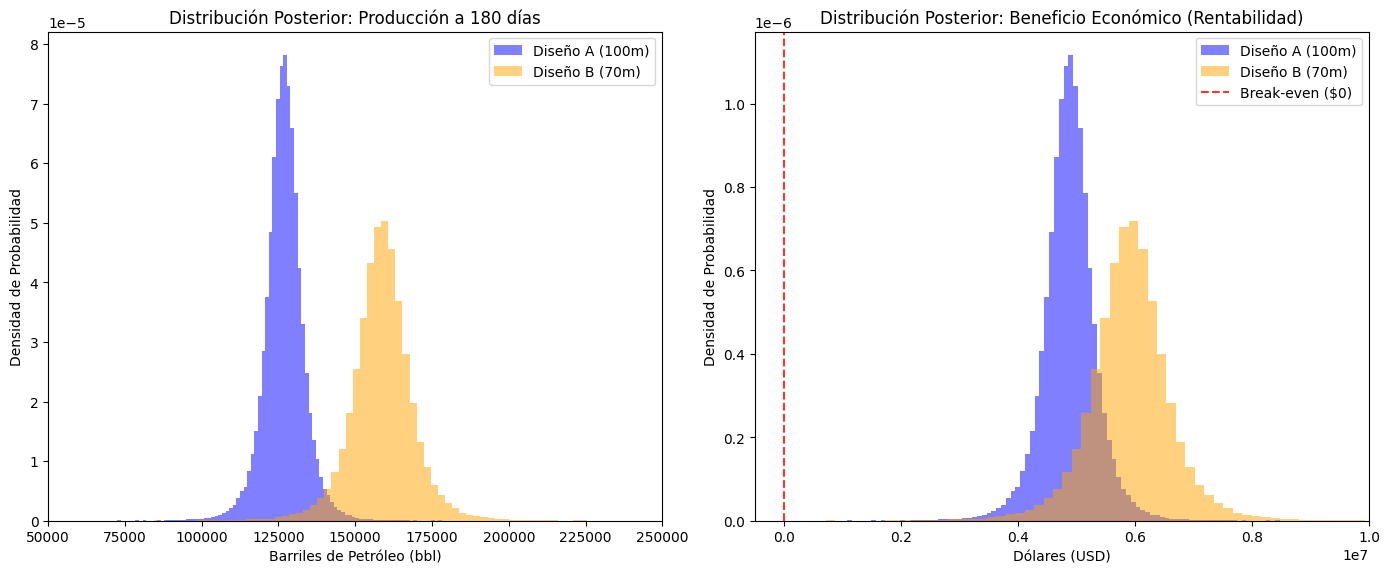

In [16]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(42)
cost_A = 4000000        # USD (100m espaciamiento)
cost_B = 5200000        # USD (70m espaciamiento)
oil_price = 70          # USD/bbl 

# PAD de prueba con 5 pozos de cada tipo
n_A, n_B = 5, 5

# Datos observados: producción real acumulada a 180 días
# Grupo A: media esperada ~120k bbl, Grupo B: media esperada ~150k bbl, 
# la diferencia (30 kbbl) es la hipótesis de que más etapas de fractura = más producción.

data_A = np.random.normal(loc=120000, scale=15000, size=n_A) # loc = Media (μ) — producción esperada
data_B = np.random.normal(loc=150000, scale=20000, size=n_B) # scale = Desviación estándar (σ) — variabilidad geológica

# INFERENCIA BAYESIANA
# Al tener muestras pequeñas (n<30) y desviación estándar poblacional desconocida, 
# la distribución posterior de la media sigue una distribución t-Student.

mean_A, std_A = np.mean(data_A), np.std(data_A, ddof=1) # ddof=delta degree of freedom, =0, sigma pobalcional divide por N, =1 sigma muestral divide por N-1.
mean_B, std_B = np.mean(data_B), np.std(data_B, ddof=1)

# Generamos 100,000 simulaciones de la verdadera media (Posterior) para cada grupo
# rvs = Random Variates Samples — genera muestras aleatorias de una distribución t-Student.
# Este bloque responde la pregunta: "Dado que observé estos 5 pozos, 
# ¿cuál podría ser la verdadera media de producción de todos los pozos posibles?"
#  df    = n_A - 1, grados de libertad = 5-1 = 4
#  ¿Qué es scale=std_A / np.sqrt(n_A)? — El Error Estándar (SEM = σ / √n): Mide la incertidumbre sobre la media, 
#  no la variabilidad de los pozos individuales, std_A grande → cada pozo varía mucho entre sí, SEM pequeño → con más pozos, más seguros estamos de la media real

n_samples = 100000
posterior_A_prod = stats.t.rvs(df=n_A-1, loc=mean_A, scale=std_A/np.sqrt(n_A), size=n_samples)
posterior_B_prod = stats.t.rvs(df=n_B-1, loc=mean_B, scale=std_B/np.sqrt(n_B), size=n_samples)

# MÉTRICAS DE NEGOCIO
# Beneficio Económico = (Producción * Precio Petróleo) - Costo Completación

posterior_A_profit = (posterior_A_prod * oil_price) - cost_A
posterior_B_profit = (posterior_B_prod * oil_price) - cost_B

# RESULTADOS DE DECISIÓN
# ¿En cuántos escenarios el Diseño B superó al A?

prob_B_better_prod = np.mean(posterior_B_prod > posterior_A_prod)
prob_B_better_profit = np.mean(posterior_B_profit > posterior_A_profit)

print(f"Éxito Técnico: Probabilidad de que B produzca más que A: {prob_B_better_prod*100:.2f}%")
print(f"Éxito Comercial: Probabilidad de que B sea MÁS RENTABLE: {prob_B_better_profit*100:.2f}%")
print(f"Beneficio Esperado Diseño A: ${np.mean(posterior_A_profit):,.0f}")
print(f"Beneficio Esperado Diseño B: ${np.mean(posterior_B_profit):,.0f}")


plt.figure(figsize=(14, 6))

# Distribuciones Posteriores de Producción
plt.subplot(1, 2, 1)
plt.hist(posterior_A_prod, bins=250, alpha=0.5, density=True, label='Diseño A (100m)', color='blue')
plt.hist(posterior_B_prod, bins=250, alpha=0.5, density=True, label='Diseño B (70m)', color='orange')
plt.xlim(50000, 250000)
plt.title('Distribución Posterior: Producción a 180 días')
plt.xlabel('Barriles de Petróleo (bbl)')
plt.ylabel('Densidad de Probabilidad')
plt.legend()

# Gráfico 2: Distribuciones Posteriores de Rentabilidad (Beneficio)
plt.subplot(1, 2, 2)
plt.hist(posterior_A_profit, bins=250, alpha=0.5, density=True, label='Diseño A (100m)', color='blue')
plt.hist(posterior_B_profit, bins=250, alpha=0.5, density=True, label='Diseño B (70m)', color='orange')
plt.xlim(-500000, 10000000)
plt.title('Distribución Posterior: Beneficio Económico (Rentabilidad)')
plt.xlabel('Dólares (USD)')
plt.ylabel('Densidad de Probabilidad')

plt.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Break-even ($0)')
plt.legend()

plt.tight_layout()
plt.show()

Para resolver este problema con un enfoque Bayesiano, dejamos de lado los valores-p (p-values) que son confusos para la gerencia, y calculamos directamente lo que al equipo técnico y financiero le importa: "¿Cuál es la probabilidad exacta de que el Diseño B sea más rentable que el Diseño A?"

En el sector petrolero, perforar pozos de prueba es carísimo. Nunca tendremos un tamaño de muestra de N=10,000 como en una página web; en su lugar, tendremos N=5 o N=10 "pozos gemelos". La estadística Bayesiana es perfecta aquí porque maneja muestras pequeñas de forma natural integrando la incertidumbre en distribuciones completas.

### **Resultados de la Simulación**


- ***Éxito Técnico:*** Probabilidad de que el Diseño B produzca más que A: 98.98%.

- ***Éxito Comercial:*** Probabilidad de que el Diseño B sea MÁS RENTABLE que A: 90.90%.

- **Beneficio Esperado Diseño A:** $4,880,548

- **Beneficio Esperado Diseño B:** $5,912,255

#### **Interpretación y Toma de Decisiones**

Diferencia entre Volúmenes y Dólares: Existe casi un 99% de certeza de que hacer las fracturas más juntas (Diseño B a 70m) saca más petróleo. El yacimiento responde físicamente al estímulo extra. Sin embargo, cuando incorporamos el delta de $1.2 Millones extra de costo, la certeza de que fue un "buen negocio" cae al 90.9%.

Riesgo Cuantificado: El decisor ahora no tiene que adivinar qué significa un p-value de 0.04. Sabe directamente que tiene un ~9% de riesgo de que este cambio de diseño termine destruyendo valor en comparación con seguir haciendo las cosas igual (Diseño A), asumiendo un precio de barril a $70.

Sensibilidad Dinámica (NPV vs Oil Price): Al tener las distribuciones (posterior_B_prod), puedes modificar el precio del petróleo en el código. Si el precio de venta del barril cae a $40, correr nuevamente este script Bayesiano mostrará automáticamente que la probabilidad de éxito comercial del Diseño B podría desplomarse a menos del 30%, recomendando inmediatamente abortar el frack de 70 metros y mantener el diseño de control (100m).
